# Library

In [1]:
import numpy as np
import torch
import gpytorch
import argparse
import time
import pickle
import scipy.io as sio

from torch.distributions import Normal
import matplotlib.pyplot as plt
import random

import roslib
import rospy
import tf as tf_ros
from nav_msgs.msg import Odometry, Path
from sensor_msgs.msg import Image
from cv_bridge import CvBridge
from geometry_msgs.msg import PoseStamped, PoseArray, Pose
import math
import cv2
import copy

import sys
sys.path.append('..')

the rosdep view is empty: call 'sudo rosdep init' and 'rosdep update'


## Check GPU

In [2]:
import torch
import numpy as np
import sys
sys.path.append('..')

from torchlib.utils import list_device,set_device

# S1: check GPU
#list_device()

# S2: default parameters
set_device(1)
np.set_printoptions(precision = 2)
torch.set_default_dtype(torch.float32)
torch.set_printoptions(precision=4)
torch.backends.cudnn.benchmark = True
torch.set_printoptions(sci_mode=False)

Using Device 1 : TITAN Xp


# Set Arguments

In [3]:
import argparse
import sys
import os
import time
import pickle

parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', type=int, default=300, help='size of mini batch')
parser.add_argument('--is_normalization', type=bool, default=True, help='whether do data normalization')
parser.add_argument('--target_image_size', default=[300, 300], nargs=2, type=int, help='Input images will be resized to this for data argumentation.')
parser.add_argument('--output_dim', default=3, type=int, help='output dimention.')
parser.add_argument('--feat_dim', default=128, type=int, help='feature dimention.')
parser.add_argument('--model_dir', type=str, default='/notebooks/global_localization/class_gps_torch', help='rnn, gru, or lstm')

parser.add_argument('--test_dataset', type=str, default=[# '/notebooks/michigan_nn_data/2012_01_08',
                                                         # '/notebooks/michigan_nn_data/2012_01_15',
                                                         # '/notebooks/michigan_nn_data/2012_01_22',
                                                         # '/notebooks/michigan_nn_data/2012_02_02',
                                                         # '/notebooks/michigan_nn_data/2012_02_04',
                                                         # '/notebooks/michigan_nn_data/2012_02_05',
                                                         '/notebooks/michigan_nn_data/2012_02_12',
                                                         # '/notebooks/michigan_nn_data/2012_03_31',
                                                         '/notebooks/michigan_nn_data/2012_04_29',
                                                         '/notebooks/michigan_nn_data/2012_05_11',
                                                         '/notebooks/michigan_nn_data/2012_06_15',
                                                         '/notebooks/michigan_nn_data/2012_08_04',
                                                         # '/notebooks/michigan_nn_data/2012_09_28'])
                                                         '/notebooks/michigan_nn_data/2012_10_28',
                                                         '/notebooks/michigan_nn_data/2012_11_16',
                                                         '/notebooks/michigan_nn_data/2012_12_01'
                                                        ] )

parser.add_argument('--train_dataset', type=str, default = ['/notebooks/michigan_nn_data/test'])
parser.add_argument('--norm_tensor', type=str, default = ['/notebooks/global_localization/norm_mean_std.pt'])

#parser.add_argument('--map_dataset', type=str, default='/home/kevin/data/michigan_gt/training')
parser.add_argument('--seed', default=1337, type=int)
parser.add_argument('--enable_ros', type=bool, default=False, help='put data into ros')

sys.argv = ['']
args = parser.parse_args()

if args.enable_ros:
    rospy.init_node('global_localization_tf_broadcaster_cnn')

# Load Dataset

In [4]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import tf.transformations as tf_tran
from tqdm import tqdm
#from PIL import Image
import numpy as np
import random

#
import gpytorch

import torch.nn as nn
import torch.optim as optim
from torchlib import resnet, vggnet, cnn_auxiliary
from torchlib.cnn_auxiliary import normalize, denormalize, denormalize_navie, get_relative_pose, translational_rotational_loss
from torchlib.utils import LocalizationDataset, display_loss, data2tensorboard
import time

transform = transforms.Compose([transforms.ToTensor()])
dataset = LocalizationDataset(dataset_dirs = args.test_dataset, \
                              image_size = args.target_image_size, \
                              transform = transform, get_pair = False, mode='evaluate')

if len(args.train_dataset)>7:
    [args.norm_mean, args.norm_std] = [torch.tensor(x) for x in dataset.get_norm()]
    torch.save([args.norm_mean, args.norm_std], *args.norm_tensor)
    print('Save norm and std:',*args.norm_tensor)
else:
    [args.norm_mean, args.norm_std] = torch.load(*args.norm_tensor)
    print('Load norm and std:',*args.norm_tensor)

    
dataloader = DataLoader(dataset, batch_size=args.batch_size, \
                        shuffle=False, num_workers=0, \
                        drop_last=False, pin_memory=True)

100%|██████████| 12683/12683 [00:16<00:00, 761.39it/s]


Load norm and std: /notebooks/global_localization/norm_mean_std.pt


# Grid

Grid_num: 32


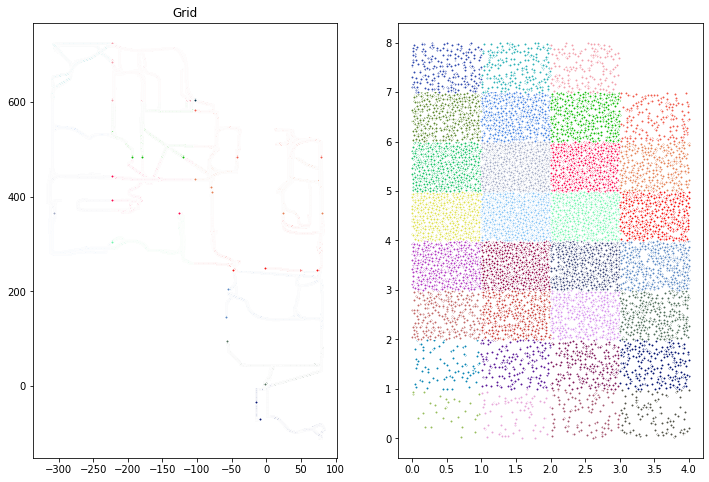

[1513, 3815, 5302, 5302, 3955, 8889, 12814, 12814, 15314, 23683, 24606, 18457, 33561, 45761, 40162, 25630, 45193, 60740, 48787, 27479, 45454, 56273, 43118, 19037, 26488, 32471, 25063, 9365, 12416, 12420, 8926, 4]


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
import pickle

class Grid:
    def __init__(self,grid_size=100.,overlap=50.,**kwargs):
        self.grid_size = grid_size
        self.overlap = overlap
        if 'data' in kwargs:
            data = kwargs['data']
            assert data.shape[1] == 2
            self.boundary_x = [np.min(data[:,0]), np.max(data[:,0])]
            self.boundary_y = [np.min(data[:,1]), np.max(data[:,1])]
            self.boundary_offset = [self.boundary_x[0],self.boundary_y[0]]
            self.num_grid_x,self.num_grid_y = self._cal_grid_num()
            self.num_grid = self.num_grid_x * self.num_grid_y
            self.weight = np.array([1, self.num_grid_x])
            self.weight_matrix = np.array([[1,self.num_grid_x,0,0],
                                           [1,0,0,self.num_grid_x],
                                           [0,self.num_grid_x,1,0],
                                           [0,0,1,self.num_grid_x]]).T
            self.grid_range_x,self.grid_range_y = self._cal_grid_range()
            self.save(os.path.join(args.model_dir,'grid.pkl'))
            print('Save Grids to',os.path.join(args.model_dir,'grid_{}_{}.pkl'.format(grid_size,overlap)))
        
    def _lenght(self):
        x_len = self.boundary_x[1] - self.boundary_x[0]
        y_len = self.boundary_y[1] - self.boundary_y[0]
        return x_len,y_len
    
    def _cal_grid_num(self):
        x_len,y_len = self._lenght()
        num_x_grid = math.ceil(x_len/self.grid_size)
        num_y_grid = math.ceil(y_len/self.grid_size)
        return num_x_grid,num_y_grid
    
    def _cal_grid_range(self):
        grid_range_x = list()
        grid_range_y = list()
        for x_inde in range(self.num_grid_x):
            x = x_inde*self.grid_size + self.boundary_x[0]
            grid_range_x.append([x-self.overlap,x+self.overlap+self.grid_size])

        for y_inde in range(self.num_grid_y):
            y = y_inde*self.grid_size + self.boundary_y[0]
            grid_range_y.append([y-self.overlap,y+self.overlap+self.grid_size])
        return np.array(grid_range_x),np.array(grid_range_y)
    
    def _grid_index(self,x,y):
        x_s = np.searchsorted(self.grid_range_x[:,1],x)
        x_s = min(max(x_s,0),self.num_grid_x-1)
        #x_index = [x_s,x_s+1] if x_s+1 < self.num_grid_x and self.grid_range_x[x_s+1,0] < x else [x_s,x_s]
        x_index = []
        for i in range(self.num_grid_x-x_s):
            if self.grid_range_x[x_s+i,0] < x:
                x_index.append(x_s + i)
        
        y_s = np.searchsorted(self.grid_range_y[:,1],y)
        y_s = min(max(y_s,0),self.num_grid_y-1)
        #y_index = [y_s,y_s+1] if y_s+1 < self.num_grid_y and self.grid_range_y[y_s+1,0] < y else [y_s,y_s]
        y_index = []
        for i in range(self.num_grid_y-y_s):
            if self.grid_range_y[y_s+i,0] < y:
                y_index.append(y_s + i)
        
        return x_index,y_index
    
    def in_grids(self,x,y):
        x_index,y_index = self._grid_index(x,y)
        #print(x_index,y_index)
        if len(x_index)<3:
            x_index += list(np.random.choice(len(x_index),3 - len(x_index)))
        if len(y_index)<3:
            y_index += list(np.random.choice(len(y_index),3 - len(y_index)))
        
        box = []
        for x_i in x_index:
            for y_i in y_index:
                box += [x_i+y_i*self.num_grid_x]
        return box
    
    def in_grids_exact_v(self,X):
        X = np.floor_divide(X - self.boundary_offset, self.grid_size)
        X = X @ self.weight
        return X
    
    def in_grids_v(self,X):
        X = X - self.boundary_offset
        X_l = np.floor_divide(X - self.overlap, self.grid_size)
        X_l[X_l<0] = 0
        X_h = np.floor_divide(X + self.overlap, self.grid_size)
        X_h[:,0][X_h[:,0]>=self.num_grid_x] = self.num_grid_x -1
        X_h[:,1][X_h[:,1]>=self.num_grid_y] = self.num_grid_y -1
        out = np.hstack([X_l,X_h]) @ self.weight_matrix
        return out

    def save(self,filename = 'grid.pkl'):
        with open(filename,'wb') as f:
            f.write(pickle.dumps(self))

    def load(self,filename = 'grid.pkl'):
        with open(filename,'rb') as f:
            dataPickle = f.read()
            self = pickle.loads(dataPickle)
        
def draw(X,grid,seed=args.seed):
    #label_mask = grid.in_grids_v(X)
    label_mask = np.zeros([X.shape[0],9])
    for i in range(X.shape[0]):
        label_mask[i] = np.array(grid.in_grids(*X[i]))

    np.random.seed(seed)
    r = lambda: np.random.randint(0,255)
    colors = ['#%02X%02X%02X' % (r(),r(),r()) for _ in range(grid.num_grid)]
    fig = plt.figure(figsize=(12, 8))
    
    ax = fig.add_subplot(1, 2, 1)
    for k, col in zip(range(grid.num_grid), colors):
        my_members = np.sum(label_mask == k,axis=1) >= 1
        ax.plot(X[my_members, 0], X[my_members, 1], 'w',
                markerfacecolor=col, marker='.')
    ax.set_title('Grid')
    #plt.show()
    
    dis = []
    for i in range(grid.num_grid):
        dis += [np.sum(np.sum(label_mask == i,axis=1)>=1)]
    
    ax = fig.add_subplot(1, 2, 2)
    for i,dense in enumerate(dis):
        row,line = divmod(i,grid.num_grid_x)
        x = np.random.rand(dense//50) + line
        y = np.random.rand(dense//50) + row
        ax.plot(x, y, 'w',markerfacecolor=colors[i], marker='.')
    plt.show()
    return dis

grid = Grid()
filename = os.path.join(args.model_dir,'grid.pkl')
with open(filename,'rb') as f:
    dataPickle = f.read()
    grid = pickle.loads(dataPickle)
print('Grid_num:',grid.num_grid)

dis = draw(np.array(dataset.Targets)[:,:2],grid)
print(dis)

# Define Model

In [6]:
from torchlib.model import Backbone, NN, GP#, GPNode_local
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
from gpytorch.likelihoods import BernoulliLikelihood

class BasicTrainer:
    def __init__(self,norm_mean,norm_std):
        self.model = None
        self.norm_mean = args.norm_mean.cuda()
        self.norm_std = args.norm_std.cuda()
        
    def disable_requires_grad(self,model):
        for param in model.parameters():
            param.requires_grad = False
            
    def load_model(self, file_name = 'pretrained.pth'):
        # load file info
        state_dict = torch.load(os.path.join(args.model_dir, file_name))
        if 'net.resnet.conv1.weight' in state_dict:
            print('Transform from old model.')
            # Part 1: backbone
            backbone_state_dict = self._from_old_model(state_dict,'backbone')
            print('Backbone parameters layer:',len(backbone_state_dict.keys()))
            self.model.backbone.load_state_dict(backbone_state_dict,strict = True)
            # Part 2: nn
            nn_state_dict = self._from_old_model(torch.load(os.path.join(args.model_dir, file_name)),'nn')
            print('NN parameters layer:',len(nn_state_dict.keys()))
            self.model.nn.load_state_dict(nn_state_dict,strict = True)
        else:
            print('Parameters layer:',len(state_dict.keys()))
            # load file to model
            self.model.load_state_dict(state_dict,strict = True)
        # Display model structure
        #print('Model Structure:')
        #for name, param in self.model.named_parameters():
        #    print(name, param.shape)
        print('Successfully loaded model...')
        print('Parameters layer:',len(self.model.state_dict().keys()))
    
    def _from_old_model(self, state_dict, select = 'backbone'):
        if select == 'backbone':
            for key in list(state_dict):
                if 'net.resnet.' in key:
                    state_dict[key.replace('net.resnet.','resnet.')] = state_dict.pop(key)
                else:
                    state_dict.pop(key)
        elif select == 'nn':
            for key in list(state_dict):
                if 'net.global_regressor.' in key:
                    state_dict[key.replace('net.global_regressor.','global_regressor.')] = state_dict.pop(key)
                elif 'net.global_context.' in key:
                    state_dict[key.replace('net.global_context.','global_context.')] = state_dict.pop(key)
                else:
                    state_dict.pop(key)
        return state_dict
    
    def save_model(self, file_name = 'model-{}-{}.pth'):
        checkpoint_path = os.path.join(args.model_dir, file_name)
        torch.save(self.model.state_dict(),checkpoint_path)
        print('Saving model to ' +  file_name)
        
    def show_require_grad(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                print (name, param.shape)

class GPNode_local(nn.Module):
    def __init__(self,inducing_points):
        super(GPNode_local,self).__init__()
        output_dim = inducing_points.shape[0] # 3-dim
        feat_dim = inducing_points.shape[-1]
        
        self.gp = GP(inducing_points)
        self.likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=output_dim) 
        
    def forward(self,input_data):
        output = self.gp(input_data)
        return output

class GPNode_global(nn.Module):
    def __init__(self,inducing_points_x,num_gp_x,inducing_points_y,num_gp_y):
        super(GPNode_global,self).__init__()
        #output_dim = inducing_points.shape[0] # num_gp
        #feat_dim = inducing_points.shape[-1]
        
        self.gp_x = GP(inducing_points_x,num_gp_x)
        self.likelihood_x = gpytorch.likelihoods.SoftmaxLikelihood(num_features=num_gp_x, num_classes=num_gp_x)
        
        self.gp_y = GP(inducing_points_y,num_gp_y)
        self.likelihood_y = gpytorch.likelihoods.SoftmaxLikelihood(num_features=num_gp_y, num_classes=num_gp_y)
        
    def forward(self,gp,input_data):
        output = gp(input_data)
        return output

class Model(nn.Module):
    def __init__(self,grid,p=0.2):
        super().__init__()
        self.num_gp = grid.num_grid
        self.dropout = nn.Dropout(p=p)
        # Part 1: basic NN
        self.backbone = Backbone()
        self.nn = NN()
        # Part 2: global GP
        inducing_points_x = torch.zeros(grid.num_grid_x, args.batch_size, args.feat_dim)
        inducing_points_y = torch.zeros(grid.num_grid_y, args.batch_size, args.feat_dim)
        self.global_gp = GPNode_global(inducing_points_x,grid.num_grid_x,
                                       inducing_points_y,grid.num_grid_y)
        
        # Part 3: local GPs
        self.local_gps = nn.ModuleList()
        for i in range(self.num_gp):
            inducing_points = torch.zeros(args.output_dim, args.batch_size, args.feat_dim)
            gp = GPNode_local(inducing_points)
            self.local_gps.append(gp)
        
    def forward_nn(self, input_data):
        dense_feat = self.backbone(input_data)
        output, feature_t, feature_r = self.nn(dense_feat)
        rot_pred = torch.split(output, [3, 4], dim=1)[1] # 4-dimention            
        return feature_t, rot_pred
    
    def forward_gp(self,gp,trans_feat):
        trans_feat = self.dropout(trans_feat)
        trans_pred = gp(trans_feat)
        return trans_pred

class Trainer(BasicTrainer):
    def __init__(self, grid, norm_mean, norm_std,
                 regressor_context_rate = [0.0,0.0],
                 is_training=True, disable_rot_learning = True, 
                 train_global_gp = True, train_local_gps = True):
        
        super().__init__(norm_mean, norm_std)
        self.model = Model(grid).cuda()
        self.grid = grid
        self.disable_rot_learning = disable_rot_learning
        self.train_global_gp = train_global_gp
        self.train_local_gps = train_local_gps
        
        self.disable_requires_grad(self.model.backbone)
        
        if is_training:
            # training tool
            self.optimizer = optim.Adam(self._optimize(regressor_context_rate))
            self.scheduler = optim.lr_scheduler.LambdaLR(optimizer=self.optimizer,
                                                             lr_lambda=lambda epoch: args.decay_rate**epoch)
        else:
            self.disable_requires_grad(self.model)
            
    def _optimize(self,regressor_context_rate):
        optimizer = list()
        # Local GPs
        if self.train_local_gps:
            optimizer += [
                    {'params': self.model.local_gps.parameters(), \
                     'lr': args.learning_rate,'weight_decay':args.weight_decay}]
        else:
            self.disable_requires_grad(self.model.local_gps)
            
        # Global GP
        if self.train_global_gp:
            optimizer += [{'params': self.model.global_gp.parameters(), \
                 'lr': args.learning_rate,'weight_decay':args.weight_decay}]
        else:
            self.disable_requires_grad(self.model.global_gp)
            
        # NN
        if regressor_context_rate[0]!=0:
            optimizer += [{'params': self.model.nn.global_regressor.parameters(), \
                 'lr': args.learning_rate * regressor_context_rate[0],'weight_decay':args.weight_decay}]
            print('Regressor learn rate:',regressor_context_rate[0])
        else:
            self.disable_requires_grad(self.model.nn.global_regressor)
                
        if regressor_context_rate[1]!=0:
            optimizer += [{'params': self.model.nn.global_context.parameters(), \
                 'lr': args.learning_rate * regressor_context_rate[1],'weight_decay':args.weight_decay}]
            print('Context learn rate:',regressor_context_rate[1])
        else:
            self.disable_requires_grad(self.model.nn.global_context)
            
        if self.disable_rot_learning and regressor_context_rate[1]!=0.0:
            print("Warning: Set 'disable_rot_learning' to False")
            self.disable_rot_learning = False
        
        if self.disable_rot_learning and regressor_context_rate[1]==0.0:
            self.disable_requires_grad(self.model.nn.global_regressor.regressor.fc1_rot)
            self.disable_requires_grad(self.model.nn.global_regressor.regressor.fc2_rot)
            self.disable_requires_grad(self.model.nn.global_regressor.regressor.fc3_rot)
            self.disable_requires_grad(self.model.nn.global_regressor.regressor.logits_r)
                
        return optimizer
    
    def train(self,x,y):
        # Step 0: zero grad
        self.optimizer.zero_grad()
        start = time.time()
        
        if self.train_local_gps:
            #label = grid.in_grids_v(y[:,:2].numpy()) # n x 4
            label = np.zeros([y.shape[0],9]) # n x 9
            for i in range(y.shape[0]):
                label[i] = np.array(grid.in_grids(*y[i,:2]))
            #noise = np.random.choice(self.model.num_gp, y.shape[0], replace=True).reshape(-1,1)
            #noise = torch.randperm(y.shape[0]).view(-1,1)
            #label = np.hstack([label,noise])
        if self.train_global_gp:
            #label_exact = grid.in_grids_exact_v(y[:,:2].numpy()) # n x ,
            #label_exact = torch.from_numpy(label_exact).cuda() # n x ,
            label_exact_index = grid.in_grids_exact_index_v(y[:,:2].numpy())
            label_exact_index = torch.from_numpy(label_exact_index).cuda()
            
        x,y = x.cuda(),y.cuda()
        
        if args.is_normalization:
            y = normalize(y,self.norm_mean, self.norm_std) # input should be 7 dim
            
        # Step 2: training
        assert self.model.training == True
        
        trans_loss = torch.tensor(0.).cuda()
        global_gp_loss = torch.tensor(0.).cuda()
        local_gps_loss = np.zeros(self.model.num_gp)
        
        trans_target, rot_target = torch.split(y, [3, 4], dim=1)
        trans_feat, rot_pred = self.model.forward_nn(x)
        
        if not self.disable_rot_learning:
            rot_loss = self._nn_loss(rot_pred,rot_target)
        
        # Step 2-1: global GP classification
        if self.train_global_gp:
            num_data = min(len(dataloader)*args.batch_size,len(dataset))
            #global_gp_loss = self._gp_loss(self.model.global_gp,num_data,trans_feat,label_exact)
            global_gp_loss = self._gp_index_loss(self.model.global_gp,num_data,trans_feat,label_exact_index)
        
        # Step 2-2: local GPs regression
        if self.train_local_gps:
            num_batch_data = 0
            for i,gp in enumerate(self.model.local_gps):
                num_data = dis[i]
                if num_data > 0:
                    label_mask = np.sum(label == i,axis=1) >= 1
                    sub_x = trans_feat[label_mask]
                    sub_y = trans_target[label_mask] # unnormalized data 
                    if sub_y.shape[0]>0:
                        gp_loss = self._gp_loss(gp,num_data,sub_x,sub_y)
                        local_gps_loss[i] = float(gp_loss)
                        trans_loss += gp_loss * int(sub_y.shape[0])
                        num_batch_data += int(sub_y.shape[0])
            trans_loss = trans_loss/num_batch_data
        
        # Step 2-3: rotation 
        if not self.disable_rot_learning:
            if self.train_global_gp:
                total_loss = trans_loss + global_gp_loss + args.lamda_weights * rot_loss
            else:
                total_loss = trans_loss + args.lamda_weights * rot_loss
        else:
            if self.train_global_gp:
                total_loss = trans_loss + global_gp_loss
            else:
                total_loss = trans_loss
            
        #Step 3: update
        if self.train_global_gp or self.train_local_gps:
            total_loss.backward()
            self.optimizer.step()
        
        batch_time = time.time() - start
        return float(total_loss), float(global_gp_loss), local_gps_loss, batch_time
        
    def _nn_loss(self,rot_pred,rot_target):
        rot_loss = 1. - torch.mean(torch.square(torch.sum(torch.mul(rot_pred,rot_target),dim=1)))
        return rot_loss
     
    def _gp_index_loss(self,gp,num_data,trans_feat,trans_target_index):
        trans_target_x = trans_target_index[:,0]
        trans_target_y = trans_target_index[:,1]
        
        trans_pred_x = gp.forward(gp.gp_x, trans_feat)
        trans_pred_y = gp.forward(gp.gp_y, trans_feat)
        
        mll_x = gpytorch.mlls.PredictiveLogLikelihood(gp.likelihood_x, gp.gp_x, 
                                            num_data=num_data).cuda()
        mll_y = gpytorch.mlls.PredictiveLogLikelihood(gp.likelihood_y, gp.gp_y, 
                                            num_data=num_data).cuda()
        
        gp_loss_x = -1.*mll_x(trans_pred_x, trans_target_x)
        gp_loss_y = -1.*mll_y(trans_pred_y, trans_target_y)
        
        loss = 0.5*gp_loss_x + 0.5*gp_loss_y
        return loss
        
    def _gp_loss(self,gp,num_data,trans_feat,trans_target):
        trans_pred = self.model.forward_gp(gp, trans_feat)
        #mll = gpytorch.mlls.VariationalELBO(gp.likelihood, gp.gp, 
        #                                    num_data=num_data).cuda()
        mll = gpytorch.mlls.PredictiveLogLikelihood(gp.likelihood, gp.gp, 
                                            num_data=num_data).cuda()
        
        trans_loss = -1.*mll(trans_pred, trans_target)
        return trans_loss
    
    def _eval_gp(self, gp, trans_pred):
        c_mean, c_var = trans_pred.mean, trans_pred.variance
        y_mean, y_var = gp.likelihood(trans_pred).mean, gp.likelihood(trans_pred).variance
        
        return y_mean, c_mean, c_var
    
    def _sample(self, mean, var, num_sample = 100):
        dist = Normal(mean, var)
        samples = dist.sample([num_sample])
        return samples
    
    def eval_classifier(self,x,y):
        label_exact = grid.in_grids_exact_v(y[:,:2].numpy()) # n x ,
        label_exact = torch.from_numpy(label_exact).cuda() # n x ,
        x = x.cuda()
        
        assert self.model.training == False
    
        trans_feat, rot_pred = self.model.forward_nn(x)
        with torch.no_grad(), gpytorch.settings.num_likelihood_samples(100):
            output = self.model.forward_gp(self.model.global_gp,trans_feat)
            output = self.model.global_gp.likelihood(output)
            pred = output.probs.mean(0).argmax(-1)
        return pred, label_exact    
    
    def eval_classifier_index(self,x,y):
        label_exact = grid.in_grids_exact_v(y[:,:2].numpy()) # n x ,
        label_exact = torch.from_numpy(label_exact).cuda() # n x ,
        x = x.cuda()
        
        assert self.model.training == False
    
        trans_feat, rot_pred = self.model.forward_nn(x)
        with torch.no_grad(), gpytorch.settings.num_likelihood_samples(100):
            output_x = self.model.forward_gp(self.model.global_gp.gp_x,trans_feat)
            output_x = self.model.global_gp.likelihood_x(output_x)
            pred_x = output_x.probs.mean(0).argmax(-1)

            output_y = self.model.forward_gp(self.model.global_gp.gp_y,trans_feat)
            output_y = self.model.global_gp.likelihood_y(output_y)
            pred_y = output_y.probs.mean(0).argmax(-1)
            
            pred = pred_x + pred_y*self.grid.num_grid_x
        return pred, label_exact
    
    def eval_forward(self,x,y,num_sample = 100, output_denormalize = True, label_from_gp = True):
        # Step 1: get data
        x,y = x.cuda(),y.cuda()
        
        if not label_from_gp:
            label = grid.in_grids_exact_v(y[:,:2].cpu().numpy()) # n x 4
        else:
            #label,_ = self.eval_classifier(x.cpu(),y.cpu())
            label,_ = self.eval_classifier_index(x.cpu(),y.cpu())
        
        # Step 2: forward
        assert self.model.training == False
        trans_feat, rot_pred = self.model.forward_nn(x)
        
        trans_pred = torch.zeros(y.shape[0],args.output_dim).cuda()
        trans_mean = torch.zeros(y.shape[0],args.output_dim).cuda()
        trans_var = torch.zeros(y.shape[0],args.output_dim).cuda()
        
        for i,gp in enumerate(self.model.local_gps):
            label_mask = label == i
            sub_x = trans_feat[label_mask]
            if sub_x.shape[0]>0:
                sub_trans_pred = self.model.forward_gp(gp,sub_x)
                sub_trans_pred, sub_trans_mean, sub_trans_var = self._eval_gp(gp, sub_trans_pred)
                if args.is_normalization and output_denormalize:
                    trans_pred[label_mask] = denormalize_navie(sub_trans_pred,self.norm_mean,self.norm_std)
                    trans_mean[label_mask] = denormalize_navie(sub_trans_mean,self.norm_mean,self.norm_std)
                    trans_var[label_mask] = sub_trans_var.mul(self.norm_std)
                else:
                    trans_pred[label_mask] = sub_trans_pred
                    trans_mean[label_mask] = sub_trans_mean
                    trans_var[label_mask] = sub_trans_var
                    
        samples = self._sample(trans_mean, trans_var, num_sample)
        
        # Step 3: split output
        trans_target, rot_target = torch.split(y, [3, 4], dim=1)
        
        return trans_pred, rot_pred, trans_target, rot_target, samples

In [16]:
class Model(nn.Module):
    def __init__(self,grid,p=0.4):
        super().__init__()
        self.num_gp = grid.num_grid
        self.dropout = nn.Dropout(p=p)
        self.bn = nn.BatchNorm1d(128)
        #self.active = nn.LeakyReLU(inplace=True)
        # Part 1: basic NN
        self.backbone = Backbone()
        self.nn = NN()
        # Part 2: global GP
        self.global_nn = nn.Linear(in_features=128,out_features=128)
        #inducing_points_x = torch.zeros(grid.num_grid_x, args.batch_size, args.feat_dim)
        inducing_points_x = torch.zeros(grid.num_grid_x, 300, args.feat_dim)
        #inducing_points_y = torch.zeros(grid.num_grid_y, args.batch_size, args.feat_dim)
        inducing_points_y = torch.zeros(grid.num_grid_y, 300, args.feat_dim)
        self.global_gp = GPNode_global(inducing_points_x,grid.num_grid_x,
                                       inducing_points_y,grid.num_grid_y)
        
        # Part 3: local GPs
        self.local_gps = nn.ModuleList()
        for i in range(self.num_gp):
            #inducing_points = torch.zeros(args.output_dim, args.batch_size, args.feat_dim)
            inducing_points = torch.zeros(args.output_dim, 300, args.feat_dim)
            gp = GPNode_local(inducing_points)
            self.local_gps.append(gp)
        
    def forward_nn(self, input_data):
        dense_feat = self.backbone(input_data)
        output, feature_t, feature_r = self.nn(dense_feat)
        rot_pred = torch.split(output, [3, 4], dim=1)[1] # 4-dimention  
        #feature_t = self.bn(feature_t)
        #feature_t = self.active(feature_t)
        return feature_t, rot_pred
    
    def forward_gp(self,gp,trans_feat,dropout = False, global_nn = False):
        if global_nn:
            trans_feat = self.global_nn(trans_feat)
            trans_feat = self.bn(trans_feat)
        if dropout:
            trans_feat = self.dropout(trans_feat)
        trans_pred = gp(trans_feat)
        return trans_pred
    
class Trainer(BasicTrainer):
    def __init__(self, grid, norm_mean, norm_std,
                 regressor_context_rate = [0.0,0.0],
                 is_training=True, disable_rot_learning = True, 
                 train_global_gp = True, train_local_gps = True):
        
        super().__init__(norm_mean, norm_std)
        self.model = Model(grid).cuda()
        self.grid = grid
        self.disable_rot_learning = disable_rot_learning
        self.train_global_gp = train_global_gp
        self.train_local_gps = train_local_gps
        
        self.disable_requires_grad(self.model.backbone)
        
        if is_training:
            # training tool
            self.optimizer = optim.Adam(self._optimize(regressor_context_rate))
            self.scheduler = optim.lr_scheduler.LambdaLR(optimizer=self.optimizer,
                                                             lr_lambda=lambda epoch: args.decay_rate**epoch)
        else:
            self.disable_requires_grad(self.model)
            
    def _optimize(self,regressor_context_rate):
        optimizer = list()
        optimizer += [
            {'params': self.model.bn.parameters(), \
             'lr': args.learning_rate,'weight_decay':args.weight_decay}]
        # Local GPs
        if self.train_local_gps:
            optimizer += [
                    {'params': self.model.local_gps.parameters(), \
                     'lr': args.learning_rate,'weight_decay':args.weight_decay}]            
        else:
            self.disable_requires_grad(self.model.local_gps)
            
        # Global GP
        if self.train_global_gp:
            optimizer += [{'params': self.model.global_gp.parameters(), \
                 'lr': args.learning_rate,'weight_decay':args.weight_decay}]
            optimizer += [{'params': self.model.global_nn.parameters(), \
                 'lr': args.learning_rate,'weight_decay':args.weight_decay}]
        else:
            self.disable_requires_grad(self.model.global_gp)
            
        # NN
        if regressor_context_rate[0]!=0:
            optimizer += [{'params': self.model.nn.global_regressor.parameters(), \
                 'lr': args.learning_rate * regressor_context_rate[0],'weight_decay':args.weight_decay}]
            print('Regressor learn rate:',regressor_context_rate[0])
        else:
            self.disable_requires_grad(self.model.nn.global_regressor)
                
        if regressor_context_rate[1]!=0:
            optimizer += [{'params': self.model.nn.global_context.parameters(), \
                 'lr': args.learning_rate * regressor_context_rate[1],'weight_decay':args.weight_decay}]
            print('Context learn rate:',regressor_context_rate[1])
        else:
            self.disable_requires_grad(self.model.nn.global_context)
            
        if self.disable_rot_learning and regressor_context_rate[1]!=0.0:
            print("Warning: Set 'disable_rot_learning' to False")
            self.disable_rot_learning = False
        
        if self.disable_rot_learning and regressor_context_rate[1]==0.0:
            self.disable_requires_grad(self.model.nn.global_regressor.regressor.fc1_rot)
            self.disable_requires_grad(self.model.nn.global_regressor.regressor.fc2_rot)
            self.disable_requires_grad(self.model.nn.global_regressor.regressor.fc3_rot)
            self.disable_requires_grad(self.model.nn.global_regressor.regressor.logits_r)
                
        return optimizer
    
    def train(self,x,y):
        # Step 0: zero grad
        self.optimizer.zero_grad()
        start = time.time()
        
        if self.train_local_gps:
            #label = grid.in_grids_v(y[:,:2].numpy()) # n x 4
            label = np.zeros([y.shape[0],9]) # n x 9
            for i in range(y.shape[0]):
                label[i] = np.array(grid.in_grids(*y[i,:2]))
            #noise = np.random.choice(self.model.num_gp, y.shape[0], replace=True).reshape(-1,1)
            #noise = torch.randperm(y.shape[0]).view(-1,1)
            #label = np.hstack([label,noise])
        if self.train_global_gp:
            #label_exact = grid.in_grids_exact_v(y[:,:2].numpy()) # n x ,
            #label_exact = torch.from_numpy(label_exact).cuda() # n x ,
            label_exact_index = grid.in_grids_exact_index_v(y[:,:2].numpy())
            label_exact_index = torch.from_numpy(label_exact_index).cuda()
            
        x,y = x.cuda(),y.cuda()
        
        if args.is_normalization:
            y = normalize(y,self.norm_mean, self.norm_std) # input should be 7 dim
            
        # Step 2: training
        assert self.model.training == True
        
        trans_loss = torch.tensor(0.).cuda()
        global_gp_loss = torch.tensor(0.).cuda()
        local_gps_loss = np.zeros(self.model.num_gp)
        
        trans_target, rot_target = torch.split(y, [3, 4], dim=1)
        trans_feat, rot_pred = self.model.forward_nn(x)
        
        if not self.disable_rot_learning:
            rot_loss = self._nn_loss(rot_pred,rot_target)
        
        # Step 2-1: global GP classification
        if self.train_global_gp:
            num_data = min(len(dataloader)*args.batch_size,len(dataset))
            #global_gp_loss = self._gp_loss(self.model.global_gp,num_data,trans_feat,label_exact)
            global_gp_loss = self._gp_index_loss(self.model.global_gp,num_data,trans_feat,label_exact_index)
        
        # Step 2-2: local GPs regression
        if self.train_local_gps:
            num_batch_data = 0
            for i,gp in enumerate(self.model.local_gps):
                num_data = dis[i]
                if num_data > 0:
                    label_mask = np.sum(label == i,axis=1) >= 1
                    sub_x = trans_feat[label_mask]
                    sub_y = trans_target[label_mask] # unnormalized data 
                    if sub_y.shape[0]>0:
                        gp_loss = self._gp_loss(gp,num_data,sub_x,sub_y)
                        local_gps_loss[i] = float(gp_loss)
                        trans_loss += gp_loss * int(sub_y.shape[0])
                        num_batch_data += int(sub_y.shape[0])
            trans_loss = trans_loss/num_batch_data
        
        # Step 2-3: rotation 
        if not self.disable_rot_learning:
            if self.train_global_gp:
                total_loss = trans_loss + global_gp_loss + args.lamda_weights * rot_loss
            else:
                total_loss = trans_loss + args.lamda_weights * rot_loss
        else:
            if self.train_global_gp:
                total_loss = trans_loss + global_gp_loss
            else:
                total_loss = trans_loss
            
        #Step 3: update
        if self.train_global_gp or self.train_local_gps:
            total_loss.backward()
            self.optimizer.step()
        
        batch_time = time.time() - start
        return float(total_loss), float(global_gp_loss), local_gps_loss, batch_time
        
    def _nn_loss(self,rot_pred,rot_target):
        rot_loss = 1. - torch.mean(torch.square(torch.sum(torch.mul(rot_pred,rot_target),dim=1)))
        return rot_loss
     
    def _gp_index_loss(self,gp,num_data,trans_feat,trans_target_index):
        trans_target_x = trans_target_index[:,0]
        trans_target_y = trans_target_index[:,1]
        
        #trans_pred_x = gp.forward(gp.gp_x, trans_feat)
        #trans_pred_y = gp.forward(gp.gp_y, trans_feat)
        trans_pred_x = self.model.forward_gp(gp.gp_x, trans_feat, dropout = True, global_nn = True)
        trans_pred_y = self.model.forward_gp(gp.gp_y, trans_feat, dropout = True, global_nn = True)
        
        mll_x = gpytorch.mlls.PredictiveLogLikelihood(gp.likelihood_x, gp.gp_x, 
                                            num_data=num_data).cuda()
        mll_y = gpytorch.mlls.PredictiveLogLikelihood(gp.likelihood_y, gp.gp_y, 
                                            num_data=num_data).cuda()
        
        gp_loss_x = -1.*mll_x(trans_pred_x, trans_target_x)
        gp_loss_y = -1.*mll_y(trans_pred_y, trans_target_y)
        
        loss = 0.5*gp_loss_x + 0.5*gp_loss_y
        return loss
        
    def _gp_loss(self,gp,num_data,trans_feat,trans_target):
        trans_pred = self.model.forward_gp(gp, trans_feat)
        #mll = gpytorch.mlls.VariationalELBO(gp.likelihood, gp.gp, 
        #                                    num_data=num_data).cuda()
        mll = gpytorch.mlls.PredictiveLogLikelihood(gp.likelihood, gp.gp, 
                                            num_data=num_data).cuda()
        
        trans_loss = -1.*mll(trans_pred, trans_target)
        return trans_loss
    
    def _eval_gp(self, gp, trans_pred):
        c_mean, c_var = trans_pred.mean, trans_pred.variance
        y_mean, y_var = gp.likelihood(trans_pred).mean, gp.likelihood(trans_pred).variance
        
        return y_mean, c_mean, c_var
    
    def _sample(self, mean, var, num_sample = 100):
        dist = Normal(mean, var)
        samples = dist.sample([num_sample])
        return samples
    
    def eval_classifier(self,x,y):
        label_exact = grid.in_grids_exact_v(y[:,:2].numpy()) # n x ,
        label_exact = torch.from_numpy(label_exact).cuda() # n x ,
        x = x.cuda()
        
        assert self.model.training == False
    
        trans_feat, rot_pred = self.model.forward_nn(x)
        with torch.no_grad(), gpytorch.settings.num_likelihood_samples(100):
            output = self.model.forward_gp(self.model.global_gp,trans_feat)
            output = self.model.global_gp.likelihood(output)
            pred = output.probs.mean(0).argmax(-1)
        return pred, label_exact    
    
    def eval_classifier_index(self,x,y):
        label_exact = grid.in_grids_exact_v(y[:,:2].numpy()) # n x ,
        label_exact = torch.from_numpy(label_exact).cuda() # n x ,
        x = x.cuda()
        
        assert self.model.training == False
    
        trans_feat, rot_pred = self.model.forward_nn(x)
        with torch.no_grad(), gpytorch.settings.num_likelihood_samples(100):
            output_x = self.model.forward_gp(self.model.global_gp.gp_x,trans_feat, dropout = True, global_nn = True)
            output_x = self.model.global_gp.likelihood_x(output_x)
            pred_x = output_x.probs.mean(0).argmax(-1)

            output_y = self.model.forward_gp(self.model.global_gp.gp_y,trans_feat, dropout = True, global_nn = True)
            output_y = self.model.global_gp.likelihood_y(output_y)
            pred_y = output_y.probs.mean(0).argmax(-1)
            
            pred = pred_x + pred_y*self.grid.num_grid_x
        return pred, label_exact
    
    def eval_forward(self,x,y,num_sample = 100, output_denormalize = True, label_from_gp = True):
        # Step 1: get data
        x,y = x.cuda(),y.cuda()
        
        if not label_from_gp:
            label = grid.in_grids_exact_v(y[:,:2].cpu().numpy()) # n x 4
        else:
            #label,_ = self.eval_classifier(x.cpu(),y.cpu())
            label,_ = self.eval_classifier_index(x.cpu(),y.cpu())
        
        # Step 2: forward
        assert self.model.training == False
        trans_feat, rot_pred = self.model.forward_nn(x)
        
        trans_pred = torch.zeros(y.shape[0],args.output_dim).cuda()
        trans_mean = torch.zeros(y.shape[0],args.output_dim).cuda()
        trans_var = torch.zeros(y.shape[0],args.output_dim).cuda()
        
        for i,gp in enumerate(self.model.local_gps):
            label_mask = label == i
            sub_x = trans_feat[label_mask]
            if sub_x.shape[0]>0:
                sub_trans_pred = self.model.forward_gp(gp,sub_x)
                sub_trans_pred, sub_trans_mean, sub_trans_var = self._eval_gp(gp, sub_trans_pred)
                if args.is_normalization and output_denormalize:
                    trans_pred[label_mask] = denormalize_navie(sub_trans_pred,self.norm_mean,self.norm_std)
                    trans_mean[label_mask] = denormalize_navie(sub_trans_mean,self.norm_mean,self.norm_std)
                    trans_var[label_mask] = sub_trans_var.mul(self.norm_std)
                else:
                    trans_pred[label_mask] = sub_trans_pred
                    trans_mean[label_mask] = sub_trans_mean
                    trans_var[label_mask] = sub_trans_var
                    
        samples = self._sample(trans_mean, trans_var, num_sample)
        
        # Step 3: split output
        trans_target, rot_target = torch.split(y, [3, 4], dim=1)
        
        return trans_pred, rot_pred, trans_target, rot_target, samples

In [17]:
trainer = Trainer(grid,args.norm_mean,args.norm_std,is_training=False)

#trainer.load_model('pretrained.pth')
trainer.load_model('model-21-10000.pth')
trainer.show_require_grad()

Parameters layer: 691
Successfully loaded model...
Parameters layer: 691


# Initialize

In [18]:
trans_errors = []
rot_errors = []
uncertainties = []
pose_map = []

total_trans_error = 0.
total_rot_error = 0.

count = 0.

is_save_map = False
is_read_map = False

trans_preds = []
trans_gts = []

rot_preds = []
rot_gts = []

pred_uncertainties = []

pred_time = []

br = tf_ros.TransformBroadcaster()

GT_POSE_TOPIC = '/gt_pose'
BIRDVIEW_TOPIC_PUB = '/bird_view'
MAP_TOPIC_PUB = '/pose_map'
PARTICLES_PUB = '/particles'
NN_LOCALIZASION_PUB = '/nn_pose'
gt_pose_pub = rospy.Publisher(GT_POSE_TOPIC, Odometry, queue_size=1)
bird_view_pub = rospy.Publisher(BIRDVIEW_TOPIC_PUB, Image, queue_size=1)
map_pub = rospy.Publisher(MAP_TOPIC_PUB, Path, queue_size=1)
particles_pub = rospy.Publisher(PARTICLES_PUB, PoseArray, queue_size=1)
nn_pose_pub = rospy.Publisher(NN_LOCALIZASION_PUB, Odometry, queue_size=1)

In [11]:
trainer.model.eval()

accs = 0
error_num = 0
for b, data in enumerate(dataloader, 0):
    x,y = data.values()
    pred, target = trainer.eval_classifier_index(x,y)
    acc = float(torch.sum(pred - target == 0))/float(target.shape[0])
    gt = target[pred - target != 0].cpu().numpy()
    offset = (pred - target)[pred - target != 0].cpu().numpy()
    pt = pred[pred - target != 0].cpu().numpy()
    if len(offset)>0 and np.abs(offset).max() > 5:
        print(np.vstack([gt,offset,pt]))
        print(offset[np.abs(offset)>5])
        num = len(offset[np.abs(offset)>5])
        error_num += num
        print("Error number:",num)
    accs += acc
    if b % 10 == 0:
        print(acc)
print('ACC:', accs/(b+1))
print('Total error number:',error_num)

0.9833333333333333
1.0
0.9966666666666667
[[ 25.  25.  25.  25.  25.  25.  25.  25.  25.  25.  25.  25.  25.  25.
   25.  25.  25.  25.  25.  25.  25.  25.  25.  25.  25.  25.  25.  25.
   25.  25.  25.  25.  25.  25.  25.  25.  25.  25.  25.  25.  25.  25.
   21.  21.  21.  21.  21.  21.  21.  21.]
 [ -3. -11. -11. -12. -12. -12. -11. -16. -12. -12. -12. -12. -12. -12.
  -12. -12. -12. -12. -12. -11. -11. -11. -11. -11. -11. -11. -11. -12.
  -12. -12. -12. -12. -12. -12. -12. -12. -12. -11. -11. -11.  -4.  -4.
    4.   4.   4.   4.   4.   4.   4.   4.]
 [ 22.  14.  14.  13.  13.  13.  14.   9.  13.  13.  13.  13.  13.  13.
   13.  13.  13.  13.  13.  14.  14.  14.  14.  14.  14.  14.  14.  13.
   13.  13.  13.  13.  13.  13.  13.  13.  13.  14.  14.  14.  21.  21.
   25.  25.  25.  25.  25.  25.  25.  25.]]
[-11. -11. -12. -12. -12. -11. -16. -12. -12. -12. -12. -12. -12. -12.
 -12. -12. -12. -12. -11. -11. -11. -11. -11. -11. -11. -11. -12. -12.
 -12. -12. -12. -12. -12. -12. -12. -1

[[13. 13. 13. 13.]
 [ 8.  8.  4.  4.]
 [21. 21. 17. 17.]]
[8. 8.]
Error number: 2
0.9866666666666667
[[ 18.  18.  18.  18.  18.  18.  18.  18.]
 [  4.   4.   4. -13. -16. -16. -12.   4.]
 [ 22.  22.  22.   5.   2.   2.   6.  22.]]
[-13. -16. -16. -12.]
Error number: 4
1.0
1.0
0.9366666666666666
[[11. 11. 11. 11. 11. 11.]
 [ 2.  5.  2.  6.  4.  4.]
 [13. 16. 13. 17. 15. 15.]]
[6.]
Error number: 1
[[15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.
  15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.
  15. 15. 15.]
 [ 9.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.
   5.  5.  9.  9.  5.  9.  5.  5.  5.  9.  9.  9.  9.  9.  5.  5.  5.  9.
   5.  9.  9.]
 [24. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20.
  20. 20. 24. 24. 20. 24. 20. 20. 20. 24. 24. 24. 24. 24. 20. 20. 20. 24.
  20. 24. 24.]]
[9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]
Error number: 12
[[ 15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.

0.9866666666666667
[[ 18.  18.  18.  18.  18.  18.  18.  18.  18.  18.  18.  18.  18.  18.]
 [  4.   4. -12. -16. -16. -16. -16. -16. -16.  -8. -12. -12. -16.  -8.]
 [ 22.  22.   6.   2.   2.   2.   2.   2.   2.  10.   6.   6.   2.  10.]]
[-12. -16. -16. -16. -16. -16. -16.  -8. -12. -12. -16.  -8.]
Error number: 12
0.9533333333333334
[[11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11.
  11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11.
  11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11.
  11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11.
  11. 11. 11. 11. 11. 11.]
 [-1. -1. -1.  2. -1. -1.  2.  9. 13. 13.  9. 10. 14. 13.  9.  9. -1. -2.
  -1. -1. -1. -1. -2. -2. -2.  2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2.
  -2. -2. -2.  2. -2. -2. 10.  2. -2.  2. -2. -2. -2.  2.  2. 10.  2.  2.
  -2.  2. -2. -2. -2. -2. -2.  9. 10. 10.  2. 10. 10. 10. 10. 10. 10.  2.
   2. -2. -1.  2. -1. 10.]
 [10. 10. 10. 13.

[[ 25.  25.  25.  25.  25.  25.  25.  25.  25.  25.  25.  25.  25.  25.
   25.  25.  25.  25.  25.  25.  25.  25.  25.  25.  25.]
 [ -4.  -4. -11.  -4.  -4.  -4.  -4. -15. -11.  -4.  -4.  -4. -11.  -4.
  -12. -16. -19.  -4.  -4.  -5.  -4.  -4.  -4.  -1.  -1.]
 [ 21.  21.  14.  21.  21.  21.  21.  10.  14.  21.  21.  21.  14.  21.
   13.   9.   6.  21.  21.  20.  21.  21.  21.  24.  24.]]
[-11. -15. -11. -11. -12. -16. -19.]
Error number: 7
0.9733333333333334
[[ 20.  20.  20.  20.  20.  20.  20.  20.  20.  20.  20.  20.  20.  20.
   20.  20.  20.  20.  20.  20.  20.  20.  20.  20.  20.  20.  20.  21.
   21.  21.  21.  21.  21.  20.  20.  20.  20.  20.  20.  20.]
 [  1.  -3.   1.   1.  -3.  -3.  -3.  -4.   1.   1.  -3.  -3.  -3.  -3.
   -3.  -3.  -3.  -3.  -3.  -3.  -3.  -3.  -3.   1.   2. -15.   1.  -1.
   -1.  -1.  -1.  -1.  -1.   1.   1.   1.   1.   1.   1.   1.]
 [ 21.  17.  21.  21.  17.  17.  17.  16.  21.  21.  17.  17.  17.  17.
   17.  17.  17.  17.  17.  17.  17.  17.  17.  21.

0.97
[[ 19.  19.  19.  19.  19.  19.  19.  19.  19.  19.  19.  19.  19.  19.
   19.  19.  19.  19.  19.  19.  19.  19.  19.  19.  19.  19.  19.  19.
   19.  19.  19.  19.  19.  19.  19.  19.  19.  19.  19.  19.  19.  19.
   19.  19.  19.  19.  19.  19.  19.  19.  19.  19.  19.  19.  19.  19.
   19.  19.  19.  19.  19.  19.  19.  19.  19.  19.  19.  19.  19.  19.
   19.  19.  19.  19.  19.  19.  19.  19.  19.  19.  19.  19.  19.  19.
   19.  19.  19.  19.  19.  19.  19.  19.  19.  19.  19.  19.  19.  19.
   19.  19.  19.  19.  19.  19.  19.  19.  19.  19.  19.  19.  19.  19.
   19.  19.  19.  19.  19.  19.  19.  19.  19.]
 [  2. -10.  -9. -10.  -5.  -6.  -6.   1.   1.  -3.  -7.  -6.  -6.  -2.
   -4.  -4.  -4.  -4.  -4.  -4.  -4.   4.  -4.  -4.  -4.  -4.  -4.  -4.
   -4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.
   -4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.
   -4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.
   -4.  -4.

In [18]:
label_exact = grid.in_grids_exact_v(y[:,:2].numpy()) # n x ,
label_exact = torch.from_numpy(label_exact).cuda() # n x ,
x = x.cuda()


trans_feat, rot_pred = trainer.model.forward_nn(x)
with torch.no_grad(), gpytorch.settings.num_likelihood_samples(100):
    output_x = trainer.model.global_gp(trainer.model.global_gp.gp_x,trans_feat)
    output_x = trainer.model.global_gp.likelihood_x(output_x)
    pred_x = output_x.probs.mean(0).argmax(-1)

    output_y = trainer.model.global_gp(trainer.model.global_gp.gp_y,trans_feat)
    output_y = trainer.model.global_gp.likelihood_y(output_y)
    pred_y = output_y.probs.mean(0).argmax(-1)

    pred = pred_x + pred_y*trainer.grid.num_grid_x

In [34]:
torch.set_printoptions(precision=2)
torch.set_printoptions(sci_mode=False)

In [19]:
trainer.model.eval()

for b, data in enumerate(dataloader, 0):
    start = time.time()
    x,y = data.values()
    trans_pred, rot_pred, trans_gt, rot_gt, samples = trainer.eval_forward(x,y,label_from_gp = True)
    
    # transform data
    trans_pred = trans_pred.cpu().numpy()
    rot_pred = rot_pred.cpu().numpy()
    trans_gt = trans_gt.cpu().numpy()
    rot_gt = rot_gt.cpu().numpy()
    
    end = time.time()
    
    if args.enable_ros:
        particles = PoseArray()
        particles.header.stamp = rospy.Time.now()
        particles.header.frame_id = 'world'
        for s in samples:
            pose = Pose()
            [pose.position.x, pose.position.y, pose.position.z] = s
            [pose.orientation.x, pose.orientation.y, pose.orientation.z, pose.orientation.w] = rot_pred[0]
            particles.poses.append(pose)
        particles_pub.publish(particles)

        [px_pred, py_pred, pz_pred] = trans_pred[0]
        [qx_pred, qy_pred, qz_pred, qw_pred] = rot_pred[0]

        br.sendTransform((px_pred, py_pred, pz_pred),
                         (qx_pred, qy_pred, qz_pred, qw_pred), rospy.Time.now(),
                         "estimation", "world")

        [px_gt, py_gt, pz_gt] = trans_gt[0]
        [qx_gt, qy_gt, qz_gt, qw_gt] = rot_gt[0]

        br.sendTransform((px_gt, py_gt, pz_gt),
                         (qx_gt, qy_gt, qz_gt, qw_gt),
                         rospy.Time.now(), "gt", "world")

        timestamp = rospy.Time.now()

        nn_pose_msg = Odometry()
        nn_pose_msg.header.frame_id = 'world'
        nn_pose_msg.header.stamp = timestamp
        nn_pose_msg.child_frame_id = 'base_link'
        nn_pose_msg.pose.pose.position.x = px_pred
        nn_pose_msg.pose.pose.position.y = py_pred
        nn_pose_msg.pose.pose.position.z = pz_pred
        [nn_pose_msg.pose.pose.orientation.x, nn_pose_msg.pose.pose.orientation.y, nn_pose_msg.pose.pose.orientation.z, nn_pose_msg.pose.pose.orientation.w] = [qx_pred, qy_pred, qz_pred, qw_pred]

        conv = np.zeros((6,6), dtype=np.float32)
        [conv[0][0], conv[1][1], conv[2][2]] = trans_cov[0]
        nn_pose_msg.pose.covariance = conv.flatten().tolist()
        nn_pose_pub.publish(nn_pose_msg)

        bridge = CvBridge()

        bird_view_img_msg = bridge.cv2_to_imgmsg(np.asarray(x[0].cpu(), dtype=np.float32), encoding="passthrough")
        stamp_now = rospy.Time.now()
        bird_view_img_msg.header.stamp = stamp_now

        bird_view_pub.publish(bird_view_img_msg)

        rospy.sleep(.0)
        cv2.waitKey(0)

        count += 1
    else:
        count += y.shape[0]
    
    trans_preds += [x for x in trans_pred]
    rot_preds += [x for x in rot_pred]
    trans_gts += [x for x in trans_gt]
    rot_gts += [x for x in rot_gt]

    trans_error = np.sqrt(np.sum((trans_pred - trans_gt)**2,axis=1))
    rot_error_1 = np.arccos(np.sum(np.multiply(rot_pred,rot_gt),axis=1))/math.pi*180
    rot_error_2 = np.arccos(np.sum(np.multiply(rot_pred,-rot_gt),axis=1))/math.pi*180
    rot_error = np.minimum(rot_error_1,rot_error_2)

    trans_errors += [x for x in trans_error]
    rot_errors += [x for x in rot_error]

    total_trans_error += np.sum(trans_error)
    total_rot_error += np.sum(rot_error)
    
    display = 1

    if b % display == 0:
        print(
            "{}/{}, translation error = {:.3f}, rotation error = {:.3f}, time/batch = {:.3f}"
            .format(
             (b+1)*args.batch_size,
            len(dataloader)*args.batch_size,
            total_trans_error / count,
            total_rot_error / count,
            end - start))

300/92100, translation error = 2.522, rotation error = 2.901, time/batch = 1.693
600/92100, translation error = 4.870, rotation error = 4.459, time/batch = 1.601
900/92100, translation error = 6.141, rotation error = 4.050, time/batch = 1.599
1200/92100, translation error = 5.411, rotation error = 4.455, time/batch = 1.584
1500/92100, translation error = 4.941, rotation error = 4.615, time/batch = 1.563
1800/92100, translation error = 4.438, rotation error = 4.588, time/batch = 1.566
2100/92100, translation error = 4.278, rotation error = 5.090, time/batch = 1.573
2400/92100, translation error = 4.018, rotation error = 4.881, time/batch = 1.566
2700/92100, translation error = 3.796, rotation error = 4.987, time/batch = 1.589
3000/92100, translation error = 3.760, rotation error = 4.944, time/batch = 1.568
3300/92100, translation error = 3.559, rotation error = 4.709, time/batch = 1.586
3600/92100, translation error = 3.558, rotation error = 4.679, time/batch = 1.581
3900/92100, transla

30300/92100, translation error = 8.434, rotation error = 5.306, time/batch = 1.602
30600/92100, translation error = 8.376, rotation error = 5.292, time/batch = 1.601
30900/92100, translation error = 8.309, rotation error = 5.285, time/batch = 1.596
31200/92100, translation error = 8.251, rotation error = 5.308, time/batch = 1.597
31500/92100, translation error = 8.192, rotation error = 5.295, time/batch = 1.608
31800/92100, translation error = 8.133, rotation error = 5.283, time/batch = 1.603
32100/92100, translation error = 8.082, rotation error = 5.268, time/batch = 1.595
32400/92100, translation error = 8.028, rotation error = 5.261, time/batch = 1.709
32700/92100, translation error = 7.969, rotation error = 5.253, time/batch = 1.628
33000/92100, translation error = 7.909, rotation error = 5.238, time/batch = 1.599
33300/92100, translation error = 7.861, rotation error = 5.231, time/batch = 1.629
33600/92100, translation error = 7.816, rotation error = 5.223, time/batch = 1.619
3390

60000/92100, translation error = 9.409, rotation error = 5.559, time/batch = 1.607
60300/92100, translation error = 9.374, rotation error = 5.548, time/batch = 1.601
60600/92100, translation error = 9.342, rotation error = 5.543, time/batch = 1.642
60900/92100, translation error = 9.308, rotation error = 5.534, time/batch = 1.603
61200/92100, translation error = 9.281, rotation error = 5.528, time/batch = 1.644
61500/92100, translation error = 9.339, rotation error = 5.558, time/batch = 1.645
61800/92100, translation error = 9.615, rotation error = 5.702, time/batch = 1.651
62100/92100, translation error = 9.579, rotation error = 5.697, time/batch = 1.598
62400/92100, translation error = 9.550, rotation error = 5.690, time/batch = 1.603
62700/92100, translation error = 9.513, rotation error = 5.679, time/batch = 1.613
63000/92100, translation error = 9.479, rotation error = 5.676, time/batch = 1.589
63300/92100, translation error = 9.480, rotation error = 5.693, time/batch = 1.651
6360

89700/92100, translation error = 10.887, rotation error = 6.690, time/batch = 1.612
90000/92100, translation error = 10.934, rotation error = 6.685, time/batch = 1.620
90300/92100, translation error = 10.906, rotation error = 6.673, time/batch = 1.602
90600/92100, translation error = 10.887, rotation error = 6.672, time/batch = 1.648
90900/92100, translation error = 10.861, rotation error = 6.673, time/batch = 1.682
91200/92100, translation error = 10.839, rotation error = 6.712, time/batch = 1.604
91500/92100, translation error = 10.813, rotation error = 6.850, time/batch = 1.603
91800/92100, translation error = 10.783, rotation error = 6.840, time/batch = 1.652
92100/92100, translation error = 10.772, rotation error = 6.842, time/batch = 0.808


In [20]:
trans_pred

array([[-48.89, 248.63,  -6.8 ],
       [-49.32, 246.61,  -6.87],
       [-46.54, 248.88,  -6.83],
       [-46.11, 249.21,  -6.83],
       [-46.2 , 252.76,  -6.85],
       [-48.45, 249.15,  -6.88],
       [-47.97, 250.88,  -6.88],
       [-47.56, 252.51,  -6.84],
       [-48.22, 249.64,  -6.87],
       [-48.82, 249.3 ,  -6.9 ],
       [-49.33, 247.62,  -6.94],
       [-50.12, 247.31,  -6.97],
       [-50.4 , 246.55,  -6.96],
       [-49.46, 246.87,  -6.93],
       [-48.65, 246.32,  -6.88],
       [-48.37, 246.91,  -6.85],
       [-46.2 , 246.7 ,  -6.87],
       [-45.13, 247.72,  -6.86],
       [-44.27, 247.89,  -6.87],
       [-44.16, 247.59,  -6.83],
       [-44.17, 247.25,  -6.84],
       [-45.08, 247.25,  -6.83],
       [-43.77, 247.68,  -6.91],
       [-44.98, 247.55,  -6.89],
       [-45.77, 247.46,  -6.94],
       [-46.14, 246.77,  -6.95],
       [-46.36, 246.54,  -6.89],
       [-45.79, 246.79,  -6.84],
       [-47.22, 244.13,  -6.82],
       [-47.61, 242.41,  -6.7 ],
       [-4

In [21]:
trans_gt

array([[-46.69, 253.22,  -6.81],
       [-46.73, 252.85,  -6.82],
       [-46.78, 252.45,  -6.82],
       [-46.83, 252.01,  -6.83],
       [-46.87, 251.52,  -6.85],
       [-46.91, 251.06,  -6.86],
       [-46.94, 250.59,  -6.87],
       [-46.96, 250.16,  -6.87],
       [-46.99, 249.75,  -6.88],
       [-47.01, 249.35,  -6.89],
       [-47.02, 249.  ,  -6.9 ],
       [-47.03, 248.69,  -6.9 ],
       [-47.05, 248.38,  -6.91],
       [-47.06, 248.05,  -6.91],
       [-47.08, 247.71,  -6.92],
       [-47.1 , 247.38,  -6.92],
       [-47.14, 247.03,  -6.93],
       [-47.19, 246.63,  -6.93],
       [-47.25, 246.26,  -6.93],
       [-47.32, 245.89,  -6.89],
       [-47.4 , 245.51,  -6.86],
       [-47.47, 245.12,  -6.82],
       [-47.54, 244.74,  -6.78],
       [-47.59, 244.37,  -6.75],
       [-47.61, 243.97,  -6.71],
       [-47.61, 243.61,  -6.68],
       [-47.59, 243.31,  -6.65],
       [-47.56, 243.06,  -6.62],
       [-47.52, 242.84,  -6.6 ],
       [-47.47, 242.61,  -6.58],
       [-4

median translation error = 2.198
median rotation error = 3.289
mean translation error = 9.141
mean rotation error = 6.842


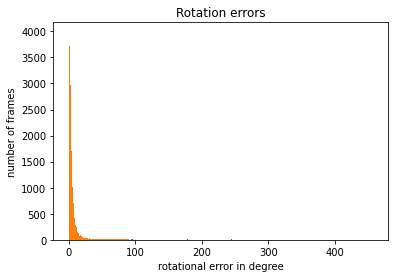

In [15]:
sio.savemat('results.mat', {'trans_pred': np.array(trans_preds), 'trans_gt': np.array(trans_gts), 'uncertainty': np.array(pred_uncertainties)})

if len(pose_map):
    np.savetxt(os.path.join(args.map_dataset, 'map.txt'), np.asarray(pose_map, dtype=np.float32))
    print("map is saved!")

plt.hist(trans_errors, bins='auto')
plt.title("Translation errors")
plt.xlabel("translational error in meters")
plt.ylabel("number of frames")
plt.savefig('terror.png', bbox_inches='tight')

plt.hist(rot_errors, bins='auto')
plt.title("Rotation errors")
plt.xlabel("rotational error in degree")
plt.ylabel("number of frames")
plt.savefig('rerror.png', bbox_inches='tight')

median_trans_errors = np.median(trans_errors)
median_rot_errors = np.median(rot_errors)
mean_trans_errors = np.mean(trans_errors)
mean_rot_errors = np.mean(rot_errors)

print("median translation error = {:.3f}".format(median_trans_errors))
print("median rotation error = {:.3f}".format(median_rot_errors))
print("mean translation error = {:.3f}".format(mean_trans_errors))
print("mean rotation error = {:.3f}".format(mean_rot_errors))   

median translation error = 2.199
median rotation error = 3.289
mean translation error = 10.772
mean rotation error = 6.842


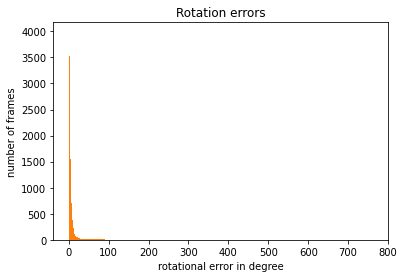

In [22]:
sio.savemat('results.mat', {'trans_pred': np.array(trans_preds), 'trans_gt': np.array(trans_gts), 'uncertainty': np.array(pred_uncertainties)})

if len(pose_map):
    np.savetxt(os.path.join(args.map_dataset, 'map.txt'), np.asarray(pose_map, dtype=np.float32))
    print("map is saved!")

plt.hist(trans_errors, bins='auto')
plt.title("Translation errors")
plt.xlabel("translational error in meters")
plt.ylabel("number of frames")
plt.savefig('terror.png', bbox_inches='tight')

plt.hist(rot_errors, bins='auto')
plt.title("Rotation errors")
plt.xlabel("rotational error in degree")
plt.ylabel("number of frames")
plt.savefig('rerror.png', bbox_inches='tight')

median_trans_errors = np.median(trans_errors)
median_rot_errors = np.median(rot_errors)
mean_trans_errors = np.mean(trans_errors)
mean_rot_errors = np.mean(rot_errors)

print("median translation error = {:.3f}".format(median_trans_errors))
print("median rotation error = {:.3f}".format(median_rot_errors))
print("mean translation error = {:.3f}".format(mean_trans_errors))
print("mean rotation error = {:.3f}".format(mean_rot_errors))   

In [23]:
def evaluate(trans_errors,rot_errors):
    t = [14301,7008,12852,9567,13580,14835,7114,12683]
    for i in range(len(t)):
        if i >0:
            t[i] += t[i-1]
    trans_errors_month = list()
    trans_errors_month.append(trans_errors[:t[0]])
    trans_errors_month.append(trans_errors[t[0]:t[1]])
    trans_errors_month.append(trans_errors[t[1]:t[2]])
    trans_errors_month.append(trans_errors[t[2]:t[3]])
    trans_errors_month.append(trans_errors[t[3]:t[4]])
    trans_errors_month.append(trans_errors[t[4]:t[5]])
    trans_errors_month.append(trans_errors[t[5]:t[6]])
    trans_errors_month.append(trans_errors[t[6]:])

    rot_errors_month = list()
    rot_errors_month.append(rot_errors[:t[0]])
    rot_errors_month.append(rot_errors[t[0]:t[1]])
    rot_errors_month.append(rot_errors[t[1]:t[2]])
    rot_errors_month.append(rot_errors[t[2]:t[3]])
    rot_errors_month.append(rot_errors[t[3]:t[4]])
    rot_errors_month.append(rot_errors[t[4]:t[5]])
    rot_errors_month.append(rot_errors[t[5]:t[6]])
    rot_errors_month.append(rot_errors[t[6]:])
    
    print('================== var translation error ==================')
    for trans_errors_i in trans_errors_month:
        print("var translation error = {:.3f}".format(np.var(trans_errors_i)))
    
    print('================== median translation error ==================')
    for trans_errors_i in trans_errors_month:
        print("median translation error = {:.3f}".format(np.median(trans_errors_i)))
        
    print('================== median rotation error ==================')
    for rot_errors_i in rot_errors_month:
        print("median rotation error = {:.3f}".format(np.median(rot_errors_i)))
    
    print('================== mean translation error ==================')
    for trans_errors_i in trans_errors_month:
        print("mean translation error = {:.3f}".format(np.mean(trans_errors_i)))
        
    print('================== mean rotation error ==================')  
    for rot_errors_i in rot_errors_month:
        print("mean rotation error = {:.3f}".format(np.mean(rot_errors_i)))
        
evaluate(trans_errors,rot_errors)

================== var translation error ==================
var translation error = 385.414
var translation error = 455.154
var translation error = 2621.602
var translation error = 2642.811
var translation error = 2212.643
var translation error = 3028.174
var translation error = 2256.304
var translation error = 2842.328
================== median translation error ==================
median translation error = 1.711
median translation error = 1.851
median translation error = 2.002
median translation error = 2.076
median translation error = 2.132
median translation error = 2.319
median translation error = 3.547
median translation error = 2.959
================== median rotation error ==================
median rotation error = 2.934
median rotation error = 2.836
median rotation error = 3.045
median rotation error = 2.972
median rotation error = 3.298
median rotation error = 3.246
median rotation error = 4.498
median rotation error = 4.396
================== mean translation error =========